# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython

ipython = get_ipython()
# Expand notebook display

from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# autoreload extension
if "autoreload" not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
from cycler import cycler

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.optimize import root_scalar

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import (
    Circle,
    RegularPolygon,
    FancyArrowPatch,
    ArrowStyle,
    Rectangle,
)
from matplotlib.ticker import (
    MultipleLocator,
    FormatStrFormatter,
    AutoMinorLocator,
    NullFormatter,
)
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path("/home/alamson/DATA/Chromatin/")
mnt_path = Path.home() / "projects/DATA/Chromatin/"
ceph_path = Path.home() / "ceph/DATA/Chromatin/"

In [2]:
# Consistent settings
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
part_min = 40

### Style settings

In [6]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": "Helvetica",
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.grid": True,
}
plt.style.use(graph_sty)
colors = cycle(mcolors.XKCD_COLORS.keys())

# register_cmaps()
# plt.rcParams['image.cmap'] = 'emct8'
# plt.rcParams['image.cmap'] = 'warm'
plt.rcParams["image.cmap"] = "YlOrRd"
# plt.rcParams['image.cmap'] = 'twilight'
# plt.rcParams['image.cmap'] = 'coolwarm'
# plt.rcParams['image.cmap'] = 'RdYlBu_r'

In [3]:
def plot_confidence_int(
    ax, time_arr, mean, std_dev, num_runs=12, color="b", ci=0.95, label="Mean", alpha=1.
):
    degrees_freedom = num_runs 
    confidence_interval = (
        stats.t.ppf((1 + ci) / 2.0, degrees_freedom) * std_dev / np.sqrt(num_runs)
    )

    _ = ax.plot(time_arr, mean, label=label, color=color, alpha=alpha)
    _ = ax.fill_between(
        time_arr,
        mean - confidence_interval,
        mean + confidence_interval,
        color=color,
        alpha=0.1,
    )

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def graph_cluster_stat_col(axarr, h5d, labels_to_graph_dict, colors):
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]
        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)

        # Plot total condensed fraction
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            12,
            color=color,
            label=label,
        )

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        plot_confidence_int(
            axarr[1],
            time_arr[:len(mean)],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        # Plot avg cluster size
        ss_mean = 1600
        mean = h5_data[:min_length, 8]
        std_dev = h5_data[:min_length, 9]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        ss_mean = 1600
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[3],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )

        #Plot variance of cluster size
        ss_mean = 1600
        mean = h5_data[:min_length, 6]
        avg_clust_mean = h5_data[:min_length, 8]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[4],
            time_arr[:min_length],
            mean/(ss_mean**2) ,
            std_dev/(ss_mean**2),
            num_runs,
            color=color,
            label=label,
        )

        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        avg_clust_mean = h5_data[:min_length, 8]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[5],
            time_arr[:min_length],
            mean/(avg_clust_mean**2) ,
            std_dev/(avg_clust_mean**2),
            # mean/(ss_mean**2) ,
            # std_dev/(ss_mean**2),
            num_runs,
            color=color,
            label=label,
        )

/tmp/ipykernel_607135/1276639102.py:57: RuntimeWarning: invalid value encountered in divide
  approx_l_bar_mean = ell_tot_mean/n_clust_mean
/tmp/ipykernel_607135/1276639102.py:143: RuntimeWarning: invalid value encountered in divide
  approx_l_bar_mean = ell_tot_mean/n_clust_mean
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of t

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

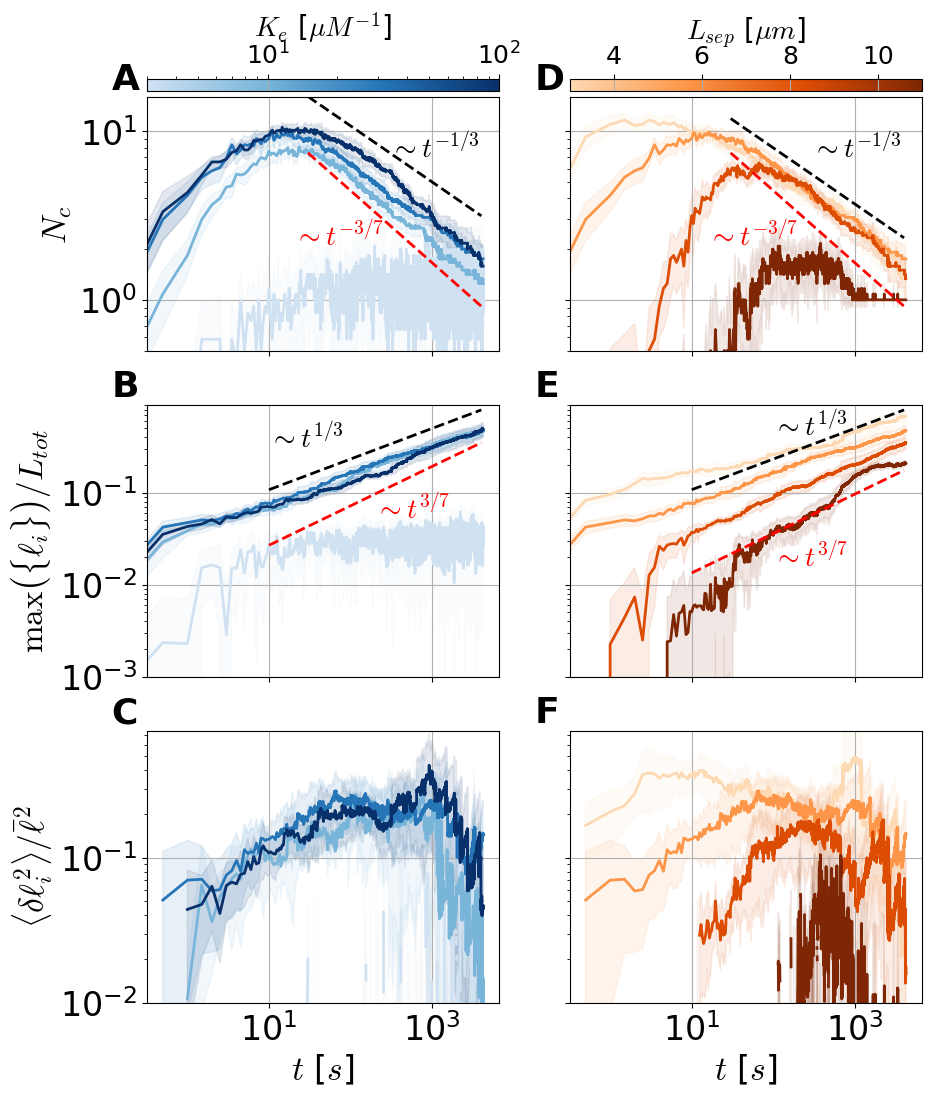

In [13]:
labels_to_graph_dict = {
    # r"$K_e = 1~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke1/",
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
}
cmap = plt.cm.Blues
n_shades = len(labels_to_graph_dict.keys())
blue_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', blue_colors)


fig, axarr = plt.subplots(3,2, figsize=(10, 12), sharex='col', sharey='row' )
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), blue_colors):
        h5_data = h5d[key]

        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0,0],
            time_arr[:len(mean)],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        ss_mean = 1600
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1,0],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )
        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]

        ell_tot_mean = h5_data[:min_length, 0]
        n_clust_mean = h5_data[:min_length, 2]
        approx_l_bar_mean = ell_tot_mean/n_clust_mean
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2,0],
            time_arr[:min_length],
            mean/(approx_l_bar_mean**2) ,
            std_dev/(approx_l_bar_mean**2),
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[0,0].set_xscale("log")

    _ = axarr[0,0].set_ylabel("$N_c$")
    _ = axarr[0,0].set_yscale("log")
    _ = axarr[0,0].set_ylim(.5)


    _ = axarr[1,0].set_ylabel( r"$\max\left(\{\ell_i\}\right) / L_{tot}$")
    _ = axarr[1,0].set_yscale("log")
    _ = axarr[1,0].set_ylim(.001, .9)

    _ = axarr[2,0].set_ylabel(r"$\langle\delta \ell_i^2\rangle/ \bar{\ell}^2$")
    _ = axarr[2,0].set_ylim(.01)
    _ = axarr[2,0].set_yscale("log")
    _ = axarr[2,0].set_xlabel("$t$ [$s$]")
    
_ = axarr[0,0].plot(np.arange(30, 4000), 50*np.power(np.arange(30, 4000), -1./3.), 'k--')
_ = axarr[0,0].plot(np.arange(30, 4000), 32*np.power(np.arange(30, 4000), -3./7.), 'r--')
_ = axarr[1,0].plot(np.arange(10, 4000), .05*np.power(np.arange(10, 4000), 1./3.), 'k--')
_ = axarr[1,0].plot(np.arange(10, 4000), .01*np.power(np.arange(10, 4000), 3./7.), 'r--')


# L_sep difference graph
labels_to_graph_dict = {
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
cmap = plt.cm.Oranges
n_shades = len(labels_to_graph_dict.keys())
orange_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
orange_cmap = mcolors.LinearSegmentedColormap.from_list('custom_oranges', orange_colors)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), orange_colors):
        h5_data = h5d[key]

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0,1],
            time_arr[:len(mean)],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        ss_mean = 1600
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1,1],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )
        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]

        ell_tot_mean = h5_data[:min_length, 0]
        n_clust_mean = h5_data[:min_length, 2]
        approx_l_bar_mean = ell_tot_mean/n_clust_mean
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2,1],
            time_arr[:min_length],
            mean/(approx_l_bar_mean**2) ,
            std_dev/(approx_l_bar_mean**2),
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[1,1].set_xscale("log")
    _ = axarr[2,1].set_xlabel("$t$ [$s$]")


_ = axarr[0,1].plot(np.arange(30, 4000), 37*np.power(np.arange(30, 4000), -1./3.), 'k--')
_ = axarr[0,1].plot(np.arange(30, 4000), 32*np.power(np.arange(30, 4000), -3./7.), 'r--')
_ = axarr[1,1].plot(np.arange(10, 4000), .05*np.power(np.arange(10, 4000), 1./3.), 'k--')
_ = axarr[1,1].plot(np.arange(10, 4000), .005*np.power(np.arange(10, 4000), 3./7.), 'r--')

# Make colorbar axes at the same time to prevent tick rearrangement
norm = mcolors.LogNorm(vmin=3, vmax=100)
sm = plt.cm.ScalarMappable(cmap=blue_cmap, norm=norm)
sm.set_array([])
cax0 = make_axes_locatable(axarr[0,0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04,  )

norm = mcolors.Normalize(vmin=3, vmax=11)
sm = plt.cm.ScalarMappable(cmap=orange_cmap, norm=norm)
sm.set_array([])
cax1 = make_axes_locatable(axarr[0,1]).append_axes("top", size="5%", pad=0.06)
cbar1 = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04,  )

cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=18)
cbar.set_label('$K_e$ [$\mu M^{-1}$]', fontsize=20)

cbar1.ax.xaxis.set_ticks_position('top')
cbar1.ax.xaxis.set_label_position('top')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('$L_{sep}$ [$\mu m$]', fontsize=20)

# Text annotations
_ = axarr[0,0].text(300, 10, "$\sim t^{-1/3}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[0,1].text(300, 10, "$\sim t^{-1/3}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[1,0].text(10,.6, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[1,1].text(100,.8, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')

_ = axarr[0,0].text(20, 3, "$\sim t^{-3/7}$", fontsize=20, fontweight='bold', va='top', color='r')
_ = axarr[1,0].text(200, .1, "$\sim t^{3/7}$", fontsize=20, fontweight='bold', va='top', color='r')
_ = axarr[0,1].text(16,3, "$\sim t^{-3/7}$", fontsize=20, fontweight='bold', va='top', color='r')
_ = axarr[1,1].text(100,.03, "$\sim t^{3/7}$", fontsize=20, fontweight='bold', va='top', color='r')

_ = axarr[0,0].text(-0.1, 1.03, "A", fontsize=26, transform=axarr[0,0].transAxes, fontweight='bold')
_ = axarr[1,0].text(-0.1, 1.03, "B", fontsize=26, transform=axarr[1,0].transAxes, fontweight='bold')
_ = axarr[2,0].text(-0.1, 1.03, "C", fontsize=26, transform=axarr[2,0].transAxes, fontweight='bold')
_ = axarr[0,1].text(-0.1, 1.03, "D", fontsize=26, transform=axarr[0,1].transAxes, fontweight='bold')
_ = axarr[1,1].text(-0.1, 1.03, "E", fontsize=26, transform=axarr[1,1].transAxes, fontweight='bold')
_ = axarr[2,1].text(-0.1, 1.03, "F", fontsize=26, transform=axarr[2,1].transAxes, fontweight='bold')

fig.savefig("Figure3/fig3_cond_dyn_Ke_Lsep_full.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_cond_dyn_Ke_Lsep_full.png", dpi=300, bbox_inches="tight")



/tmp/ipykernel_607135/4074364930.py:57: RuntimeWarning: invalid value encountered in divide
  approx_l_bar_mean = ell_tot_mean/n_clust_mean
/tmp/ipykernel_607135/4074364930.py:143: RuntimeWarning: invalid value encountered in divide
  approx_l_bar_mean = ell_tot_mean/n_clust_mean
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of t

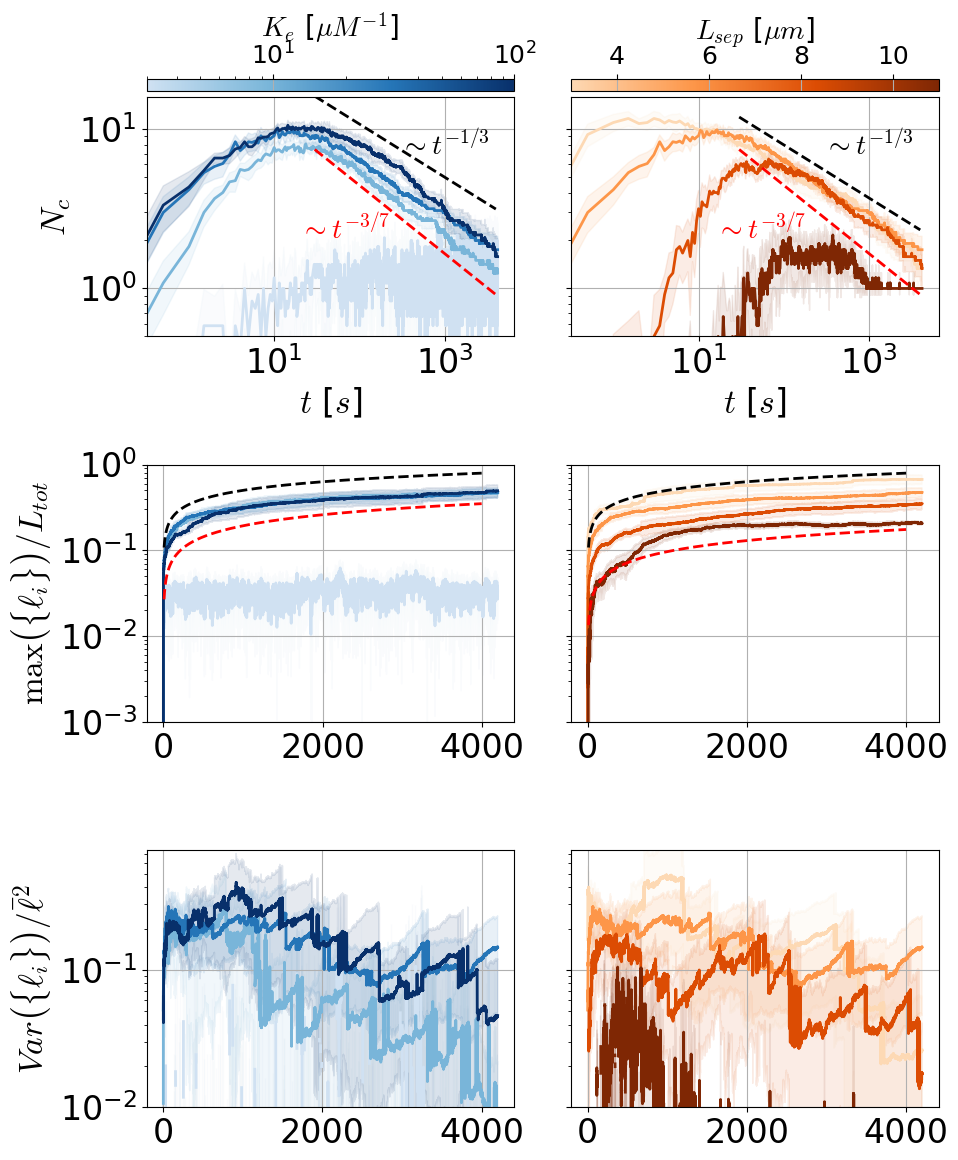

In [14]:
labels_to_graph_dict = {
    # r"$K_e = 1~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke1/",
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
}
cmap = plt.cm.Blues
n_shades = len(labels_to_graph_dict.keys())
blue_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', blue_colors)


fig, axarr = plt.subplots(3,2, figsize=(10, 12), sharey='row' )
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), blue_colors):
        h5_data = h5d[key]

        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0,0],
            time_arr[:len(mean)],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        ss_mean = 1600
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1,0],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )
        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]

        ell_tot_mean = h5_data[:min_length, 0]
        n_clust_mean = h5_data[:min_length, 2]
        approx_l_bar_mean = ell_tot_mean/n_clust_mean
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2,0],
            time_arr[:min_length],
            mean/(approx_l_bar_mean**2) ,
            std_dev/(approx_l_bar_mean**2),
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[0,0].set_xscale("log")

    _ = axarr[0,0].set_ylabel("$N_c$")
    _ = axarr[0,0].set_yscale("log")
    _ = axarr[0,0].set_ylim(.5)


    _ = axarr[1,0].set_ylabel( r"$\max\left(\{\ell_i\}\right) / L_{tot}$")
    _ = axarr[1,0].set_yscale("log")
    _ = axarr[1,0].set_ylim(.001, 1)

    _ = axarr[2,0].set_ylabel(r"$\langle\delta \ell_i^2\rangle/ \bar{\ell}^2$")
    _ = axarr[2,0].set_ylim(.01)
    _ = axarr[2,0].set_yscale("log")
    _ = axarr[0,0].set_xlabel("$t$ [$s$]")
    
_ = axarr[0,0].plot(np.arange(30, 4000), 50*np.power(np.arange(30, 4000), -1./3.), 'k--')
_ = axarr[0,0].plot(np.arange(30, 4000), 32*np.power(np.arange(30, 4000), -3./7.), 'r--')
_ = axarr[1,0].plot(np.arange(10, 4000), .05*np.power(np.arange(10, 4000), 1./3.), 'k--')
_ = axarr[1,0].plot(np.arange(10, 4000), .01*np.power(np.arange(10, 4000), 3./7.), 'r--')


# L_sep difference graph
labels_to_graph_dict = {
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
cmap = plt.cm.Oranges
n_shades = len(labels_to_graph_dict.keys())
orange_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
orange_cmap = mcolors.LinearSegmentedColormap.from_list('custom_oranges', orange_colors)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), orange_colors):
        h5_data = h5d[key]

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0,1],
            time_arr[:len(mean)],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        ss_mean = 1600
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1,1],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )
        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]

        ell_tot_mean = h5_data[:min_length, 0]
        n_clust_mean = h5_data[:min_length, 2]
        approx_l_bar_mean = ell_tot_mean/n_clust_mean
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2,1],
            time_arr[:min_length],
            mean/(approx_l_bar_mean**2) ,
            std_dev/(approx_l_bar_mean**2),
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[0,1].set_xscale("log")
    _ = axarr[0,1].set_xlabel("$t$ [$s$]")

_ = axarr[0,1].plot(np.arange(30, 4000), 37*np.power(np.arange(30, 4000), -1./3.), 'k--')
_ = axarr[0,1].plot(np.arange(30, 4000), 32*np.power(np.arange(30, 4000), -3./7.), 'r--')
_ = axarr[1,1].plot(np.arange(10, 4000), .05*np.power(np.arange(10, 4000), 1./3.), 'k--')
_ = axarr[1,1].plot(np.arange(10, 4000), .005*np.power(np.arange(10, 4000), 3./7.), 'r--')

# Make colorbar axes at the same time to prevent tick rearrangement
norm = mcolors.LogNorm(vmin=3, vmax=100)
sm = plt.cm.ScalarMappable(cmap=blue_cmap, norm=norm)
sm.set_array([])
cax0 = make_axes_locatable(axarr[0,0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04,  )

norm = mcolors.Normalize(vmin=3, vmax=11)
sm = plt.cm.ScalarMappable(cmap=orange_cmap, norm=norm)
sm.set_array([])
cax1 = make_axes_locatable(axarr[0,1]).append_axes("top", size="5%", pad=0.06)
cbar1 = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04,  )

cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=18)
cbar.set_label('$K_e$ [$\mu M^{-1}$]', fontsize=20)

cbar1.ax.xaxis.set_ticks_position('top')
cbar1.ax.xaxis.set_label_position('top')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('$L_{sep}$ [$\mu m$]', fontsize=20)

# Text annotations
_ = axarr[0,0].text(300, 10, "$\sim t^{-1/3}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[0,1].text(300, 10, "$\sim t^{-1/3}$", fontsize=20, fontweight='bold', va='top')
# _ = axarr[1,0].text(10,.6, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')
# _ = axarr[1,1].text(100,.8, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')

_ = axarr[0,0].text(20, 3, "$\sim t^{-3/7}$", fontsize=20, fontweight='bold', va='top', color='r')
# _ = axarr[1,0].text(200, .1, "$\sim t^{3/7}$", fontsize=20, fontweight='bold', va='top', color='r')
_ = axarr[0,1].text(16,3, "$\sim t^{-3/7}$", fontsize=20, fontweight='bold', va='top', color='r')
# _ = axarr[1,1].text(100,.03, "$\sim t^{3/7}$", fontsize=20, fontweight='bold', va='top', color='r')

# _ = axarr[0,0].text(-0.1, 1.03, "A", fontsize=26, transform=axarr[0,0].transAxes, fontweight='bold')
# _ = axarr[1,0].text(-0.1, 1.03, "B", fontsize=26, transform=axarr[1,0].transAxes, fontweight='bold')
# _ = axarr[2,0].text(-0.1, 1.03, "C", fontsize=26, transform=axarr[2,0].transAxes, fontweight='bold')
# _ = axarr[0,1].text(-0.1, 1.03, "D", fontsize=26, transform=axarr[0,1].transAxes, fontweight='bold')
# _ = axarr[1,1].text(-0.1, 1.03, "E", fontsize=26, transform=axarr[1,1].transAxes, fontweight='bold')
# _ = axarr[2,1].text(-0.1, 1.03, "F", fontsize=26, transform=axarr[2,1].transAxes, fontweight='bold')
fig.tight_layout()




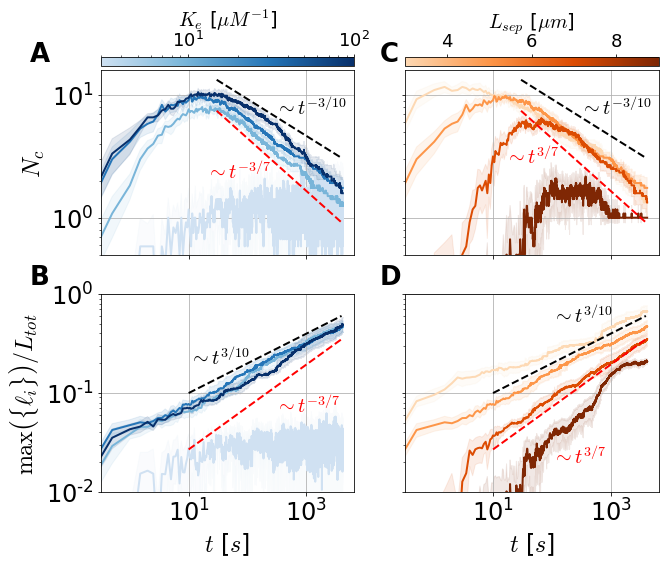

In [28]:
labels_to_graph_dict = {
    # r"$K_e = 1~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke1/",
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
}
cmap = plt.cm.Blues
n_shades = len(labels_to_graph_dict.keys())
blue_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', blue_colors)


fig, axarr = plt.subplots(2,2, figsize=(10, 8), sharex='col', sharey='row' )
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), blue_colors):
        h5_data = h5d[key]

        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0,0],
            time_arr[:len(mean)],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        ss_mean = 1600
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1,0],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[0,0].set_xscale("log")

    _ = axarr[0,0].set_ylabel("$N_c$")
    _ = axarr[0,0].set_yscale("log")
    _ = axarr[0,0].set_ylim(.5)


    _ = axarr[1,0].set_ylabel( r"$\max\left(\{\ell_i\}\right) / L_{tot}$")
    _ = axarr[1,0].set_yscale("log")
    _ = axarr[1,0].set_ylim(.01, 1)
    _ = axarr[1,0].set_xlabel("$t$ [$s$]")

    
_ = axarr[0,0].plot(np.arange(30, 4000), 37*np.power(np.arange(30, 4000), -3./10.), 'k--')
_ = axarr[0,0].plot(np.arange(30, 4000), 32*np.power(np.arange(30, 4000), -3./7.), 'r--')
_ = axarr[1,0].plot(np.arange(10, 4000), .05*np.power(np.arange(10, 4000), 3./10.), 'k--')
_ = axarr[1,0].plot(np.arange(10, 4000), .01*np.power(np.arange(10, 4000), 3./7.), 'r--')


# L_sep difference graph
labels_to_graph_dict = {
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
cmap = plt.cm.Oranges
n_shades = len(labels_to_graph_dict.keys())
orange_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
orange_cmap = mcolors.LinearSegmentedColormap.from_list('custom_oranges', orange_colors)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), orange_colors):
        h5_data = h5d[key]

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0,1],
            time_arr[:len(mean)],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        ss_mean = 1600
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1,1],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[1,1].set_xscale("log")
    _ = axarr[1,1].set_xlabel("$t$ [$s$]")

_ = axarr[0,1].plot(np.arange(30, 4000), 37*np.power(np.arange(30, 4000), -3./10.), 'k--')
_ = axarr[0,1].plot(np.arange(30, 4000), 32*np.power(np.arange(30, 4000), -3./7.), 'r--')
_ = axarr[1,1].plot(np.arange(10, 4000), .05*np.power(np.arange(10, 4000), 3./10.), 'k--')
_ = axarr[1,1].plot(np.arange(10, 4000), .01*np.power(np.arange(10, 4000), 3./7.), 'r--')

# Make colorbar axes at the same time to prevent tick rearrangement
norm = mcolors.LogNorm(vmin=3, vmax=100)
sm = plt.cm.ScalarMappable(cmap=blue_cmap, norm=norm)
sm.set_array([])
cax0 = make_axes_locatable(axarr[0,0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04,  )
cbar.set_label('$K_e$ [$\mu M^{-1}$]', fontsize=20)

norm = mcolors.Normalize(vmin=3, vmax=9)
sm = plt.cm.ScalarMappable(cmap=orange_cmap, norm=norm)
sm.set_array([])
cax1 = make_axes_locatable(axarr[0,1]).append_axes("top", size="5%", pad=0.06)
cbar1 = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04,  )
cbar1.set_label('$L_{sep}$ [$\mu m$]', fontsize=20)

cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=18)

cbar1.ax.xaxis.set_ticks_position('top')
cbar1.ax.xaxis.set_label_position('top')
cbar1.ax.tick_params(labelsize=18)

# Text annotations
_ = axarr[0,0].text(300, 10, "$\sim t^{-3/10}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[0,1].text(300, 10, "$\sim t^{-3/10}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[1,0].text(10,.3, "$\sim t^{3/10}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[1,1].text(100,.8, "$\sim t^{3/10}$", fontsize=20, fontweight='bold', va='top')

_ = axarr[0,0].text(20, 3, "$\sim t^{-3/7}$", fontsize=20, fontweight='bold', va='top', color='r')
_ = axarr[1,0].text(300, .1, "$\sim t^{-3/7}$", fontsize=20, fontweight='bold', va='top', color='r')
_ = axarr[0,1].text(16,4, "$\sim t^{3/7}$", fontsize=20, fontweight='bold', va='top', color='r')
_ = axarr[1,1].text(100,.03, "$\sim t^{3/7}$", fontsize=20, fontweight='bold', va='top', color='r')

_ = axarr[0,0].text(-0.28, 1.05, "A", fontsize=26, transform=axarr[0,0].transAxes, fontweight='bold')
_ = axarr[1,0].text(-0.28, 1.05, "B", fontsize=26, transform=axarr[1,0].transAxes, fontweight='bold')
_ = axarr[0,1].text(-0.1, 1.05, "C", fontsize=26, transform=axarr[0,1].transAxes, fontweight='bold')
_ = axarr[1,1].text(-0.1, 1.05, "D", fontsize=26, transform=axarr[1,1].transAxes, fontweight='bold')


# fig.tight_layout()
fig.savefig("Figure3/fig3_cond_dyn_Ke_Lsep.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_cond_dyn_Ke_Lsep.png", dpi=300, bbox_inches="tight")



AttributeError: 'numpy.ndarray' object has no attribute 'transAxes'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


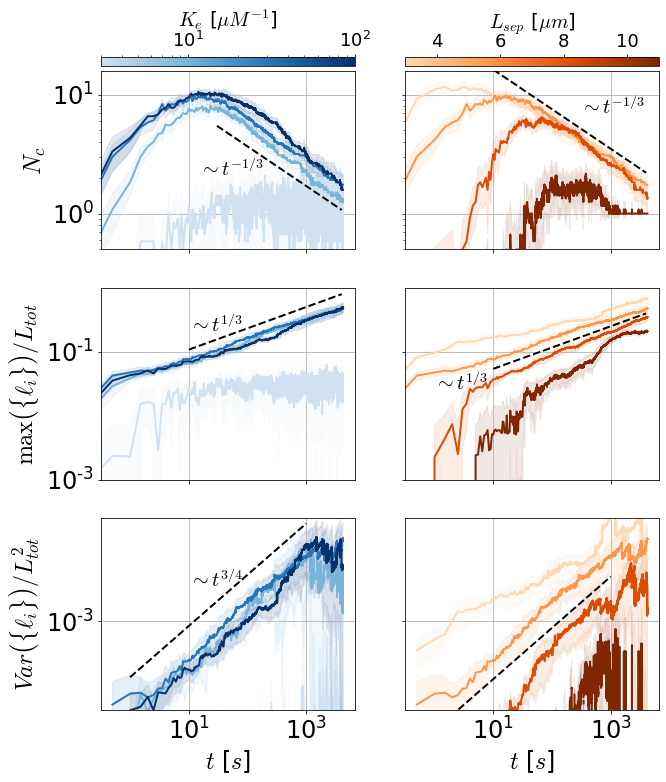

In [7]:
labels_to_graph_dict = {
    # r"$K_e = 1~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke1/",
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
}
cmap = plt.cm.Blues
n_shades = len(labels_to_graph_dict.keys())
blue_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', blue_colors)


fig, axarr = plt.subplots(3,2, figsize=(10, 12), sharex='col', sharey='row' )
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), blue_colors):
        h5_data = h5d[key]

        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0,0],
            time_arr[:len(mean)],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        ss_mean = 1600
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1,0],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )
        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2,0],
            time_arr[:min_length],
            mean/(1600**2) ,
            std_dev/(1600**2),
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[0,0].set_xscale("log")

    _ = axarr[0,0].set_ylabel("$N_c$")
    _ = axarr[0,0].set_yscale("log")
    _ = axarr[0,0].set_ylim(.5)


    _ = axarr[1,0].set_ylabel( r"$\max\left(\{\ell_i\}\right) / L_{tot}$")
    _ = axarr[1,0].set_yscale("log")
    _ = axarr[1,0].set_ylim(.001, 1)

    _ = axarr[2,0].set_ylabel(r"$Var\left(\{\ell_i\}\right)/ L_{tot}^2$")
    _ = axarr[2,0].set_ylim(.00005)
    _ = axarr[2,0].set_yscale("log")
    _ = axarr[2,0].set_xlabel("$t$ [$s$]")
    
_ = axarr[0,0].plot(np.arange(30, 4000), 17*np.power(np.arange(30, 4000), -1./3.), 'k--', label=r'$1/N$')
_ = axarr[1,0].plot(np.arange(10, 4000), .05*np.power(np.arange(10, 4000), 1./3.), 'k--', label=r'$1/N$')
_ = axarr[2,0].plot(np.arange(1, 1000), .00015*np.power(np.arange(1, 1000), 3/4.), 'k--', label=r'$1/N$')


# L_sep difference graph
labels_to_graph_dict = {
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
cmap = plt.cm.Oranges
n_shades = len(labels_to_graph_dict.keys())
orange_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
orange_cmap = mcolors.LinearSegmentedColormap.from_list('custom_oranges', orange_colors)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), orange_colors):
        h5_data = h5d[key]

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0,1],
            time_arr[:len(mean)],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        ss_mean = 1600
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1,1],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )
        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2,1],
            time_arr[:min_length],
            mean/(1600**2) ,
            std_dev/(1600**2),
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[1,1].set_xscale("log")
    _ = axarr[2,1].set_xlabel("$t$ [$s$]")

_ = axarr[0,1].plot(np.arange(10, 4000), 35*np.power(np.arange(10, 4000), -1./3.), 'k--', label=r'$1/N$')
_ = axarr[1,1].plot(np.arange(10, 4000), .025*np.power(np.arange(10, 4000), 1./3.), 'k--', label=r'$1/N$')
_ = axarr[2,1].plot(np.arange(1, 1000), .000025*np.power(np.arange(1, 1000), 3/4.), 'k--', label=r'$1/N$')

# Make colorbar axes at the same time to prevent tick rearrangement
norm = mcolors.LogNorm(vmin=3, vmax=100)
sm = plt.cm.ScalarMappable(cmap=blue_cmap, norm=norm)
sm.set_array([])
cax0 = make_axes_locatable(axarr[0,0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04,  )

norm = mcolors.Normalize(vmin=3, vmax=11)
sm = plt.cm.ScalarMappable(cmap=orange_cmap, norm=norm)
sm.set_array([])
cax1 = make_axes_locatable(axarr[0,1]).append_axes("top", size="5%", pad=0.06)
cbar1 = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04,  )

cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=18)
cbar.set_label('$K_e$ [$\mu M^{-1}$]', fontsize=20)

cbar1.ax.xaxis.set_ticks_position('top')
cbar1.ax.xaxis.set_label_position('top')
cbar1.ax.tick_params(labelsize=18)
cbar1.set_label('$L_{sep}$ [$\mu m$]', fontsize=20)

# Text annotations
_ = axarr[0,0].text(15, 3, "$\sim t^{-1/3}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[0,1].text(300, 10, "$\sim t^{-1/3}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[1,0].text(10,.4, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[1,1].text(1,.05, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')
_ = axarr[2,0].text(10,.006, "$\sim t^{3/4}$", fontsize=20, fontweight='bold', va='top')

_ = axarr[0,0].text(-0.2, 0.95, "A", fontsize=28, transform=axarr[0,0].transAxes, fontweight='bold')
_ = axarr[1,0].text(-0.22, 0.95, "B", fontsize=28, transform=axarr[1,0].transAxes, fontweight='bold')
_ = axarr[2,0].text(-0.2, 0.95, "C", fontsize=28, transform=axarr[2,0].transAxes, fontweight='bold')



fig.tight_layout()
fig.savefig("Figure3/fig3_cond_dyn_Ke_Lsep_full.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_cond_dyn_Ke_Lsep_full.png", dpi=300, bbox_inches="tight")



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


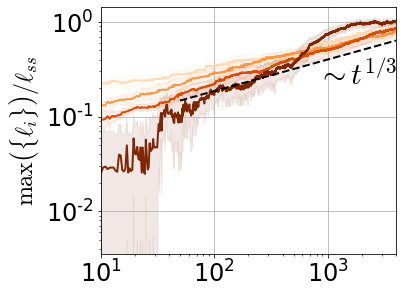

In [7]:
labels_to_graph_dict = {
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
cmap = plt.cm.Oranges
n_shades = len(labels_to_graph_dict.keys())
colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
new_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', colors)

fig, axarr = plt.subplots(1,1, figsize=(6, 4.5))

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        ss_mean = h5_data[-time_arr.size // 5 :, 0].mean()
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]

        # Plot chain in largest cluster
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr,
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )


    _ = axarr.set_xscale("log")

    _ = axarr.set_ylabel( r"$\max\left(\{\ell_i\}\right) / \ell_{ss}$")


_ = axarr.set_yscale("log")

_ = axarr.plot(np.arange(50, 4000), .04*np.power(np.arange(50, 4000), 1./3.), 'k--')
_ = axarr.annotate(r"$\sim t^{1/3}$", (800, .4), fontsize=30, fontweight='bold', va='top')
_ = axarr.set_xlim(10, 4000)


fig.tight_layout()
fig.savefig("Figure2/fig3_cond_dyn_Lsep_lss.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_cond_dyn_Lsep_lss_inset.png", dpi=300, bbox_inches="tight")



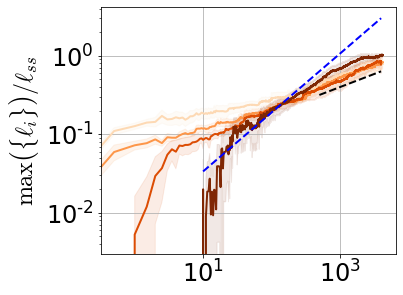

In [8]:
labels_to_graph_dict = {
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke100",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke100/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke100",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke100",
}
cmap = plt.cm.Oranges
n_shades = len(labels_to_graph_dict.keys())
colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
new_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', colors)

fig, axarr = plt.subplots(1,1, figsize=(6, 4.5))

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        ss_mean = h5_data[-time_arr.size // 5 :, 0].mean()
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]

        # Plot chain in largest cluster
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr,
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )


    _ = axarr.set_xscale("log")

    _ = axarr.set_ylabel( r"$\max\left(\{\ell_i\}\right) / \ell_{ss}$")


_ = axarr.set_yscale("log")


# cbar.ax.set_position([0.15, 0.95, 0.7, 0.02])
# cbar.set_ticks(np.arange(n_shades))
# cbar.set_ticklabels(list(labels_to_graph_dict.keys()))
_ = axarr.plot(np.arange(500, 4000), .04*np.power(np.arange(500, 4000), 1./3.), 'k--')
_ = axarr.plot(np.arange(10, 4000), .006*np.power(np.arange(10, 4000), 3./4.), 'b--')


fig.tight_layout()
# fig.savefig("Figure2/fig3_cond_dyn_Lsep_lss.png", dpi=300, bbox_inches="tight")
# fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_cond_dyn_Lsep_lss_inset.png", dpi=300, bbox_inches="tight")



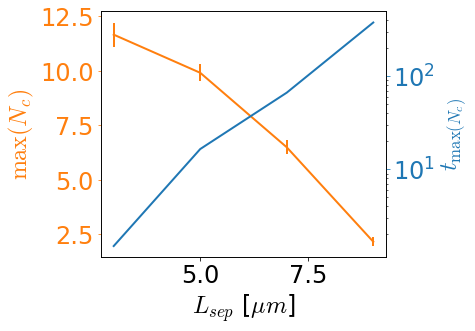

In [44]:

fig, axarr = plt.subplots(1,1, figsize=(7, 5), sharex='col', sharey='row' )
# L_sep difference graph
labels_to_graph_dict = {
    3: "Pin3.0um_Ke30",
    5: "Pin5.0um_Ke30/",
    7: "Pin7.0um_Ke30/",
    9: "Pin9.0um_Ke30",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
cmap = plt.cm.Oranges
n_shades = len(labels_to_graph_dict.keys())
orange_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
orange_cmap = mcolors.LinearSegmentedColormap.from_list('custom_oranges', orange_colors)


with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:

    time_arr = h5d["time"][...]
    max_arr = []
    max_std_arr = []
    time_max_arr = []
    sep_arr = []
    for (label, key), color in zip(labels_to_graph_dict.items(), orange_colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        # Plot number of clusters

        mean = h5_data[:, 2]
        std_dev = h5_data[:, 3]/np.sqrt(num_runs)

        max_arr.append(mean.max())
        max_std_arr.append(std_dev[np.argmax(mean)])
        time_max_arr.append(time_arr[np.argmax(mean)])
        sep_arr.append(label)
    
    _ = axarr.errorbar(sep_arr, max_arr, yerr=max_std_arr, color='tab:orange')
    _ = axarr.set_ylabel(r"$\max(N_c)$")
    _ = axarr.yaxis.label.set_color('tab:orange')
    _ = axarr.tick_params(axis='y', colors='tab:orange')
    _ = axarr.set_xlabel(r"$L_{sep}$ [$\mu m$]")
    
    ax1 = axarr.twinx()
    # Remove gridlines
    ax1.grid(False)
    axarr.grid(False)


    _ = ax1.plot(sep_arr, time_max_arr, color='tab:blue')
    _ = ax1.set_ylabel(r"$t_{\max(N_c)}$")
    _ = ax1.set_xlabel(r"$L_{sep}$ [$\mu m$]")
    _ = ax1.set_yscale('log')
    _ = ax1.yaxis.label.set_color('tab:blue')
    _ = ax1.tick_params(axis='y', colors='tab:blue')
    
    # axarr[0,0].bar(np.arange(len(max_arr)), max_arr, yerr=max_std_arr, color=orange_colors)



fig.tight_layout()
fig.savefig("Figure3/fig3_supp_maxn_tmax_vs_lsep.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_supp_maxn_tmax_vs_lsep.png", dpi=300, bbox_inches="tight")

# I need to do a better job analyzing this data but I don't have time right now.


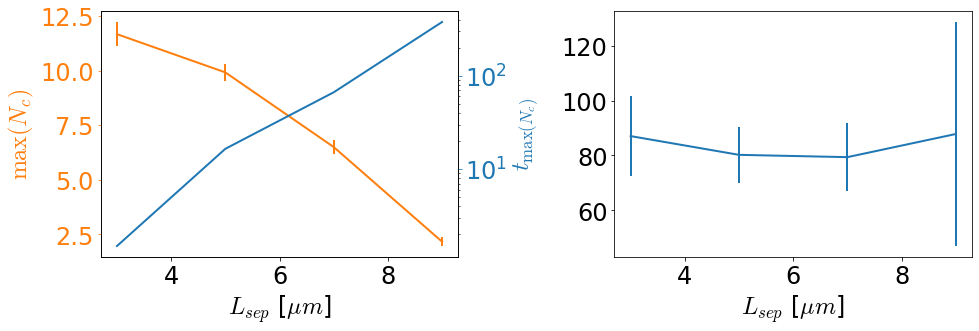

In [8]:

fig, axarr = plt.subplots(1,2, figsize=(14, 5), sharex=True)
# L_sep difference graph
labels_to_graph_dict = {
    3: "Pin3.0um_Ke30",
    5: "Pin5.0um_Ke30/",
    7: "Pin7.0um_Ke30/",
    9: "Pin9.0um_Ke30",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
cmap = plt.cm.Oranges
n_shades = len(labels_to_graph_dict.keys())
orange_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
orange_cmap = mcolors.LinearSegmentedColormap.from_list('custom_oranges', orange_colors)


with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:

    time_arr = h5d["time"][...]
    max_arr = []
    max_std_arr = []
    ell_max_arr = []
    ell_max_std_arr = []
    time_max_arr = []
    sep_arr = []
    for (label, key), color in zip(labels_to_graph_dict.items(), orange_colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        # Plot number of clusters

        nc_mean = h5_data[:, 2]
        nc_std_dev = h5_data[:, 3]/np.sqrt(num_runs)
        ell_mean = h5_data[:min_length, 8]
        ell_std_dev = h5_data[:min_length, 9]
        max_arr.append(nc_mean.max())
        max_std_arr.append(nc_std_dev[np.argmax(nc_mean)])
        ell_max_arr.append(ell_mean[np.argmax(nc_mean)])
        ell_max_std_arr.append(ell_std_dev[np.argmax(nc_mean)])
        time_max_arr.append(time_arr[np.argmax(nc_mean)])
        sep_arr.append(label)
    
    _ = axarr[0].errorbar(sep_arr, max_arr, yerr=max_std_arr, color='tab:orange')
    _ = axarr[1].errorbar(sep_arr, ell_max_arr, yerr=ell_max_std_arr)
    _ = axarr[0].set_ylabel(r"$\max(N_c)$")
    _ = axarr[0].yaxis.label.set_color('tab:orange')
    _ = axarr[0].tick_params(axis='y', colors='tab:orange')
    _ = axarr[0].set_xlabel(r"$L_{sep}$ [$\mu m$]")
    _ = axarr[1].set_xlabel(r"$L_{sep}$ [$\mu m$]")
    
    ax1 = axarr[0].twinx()
    # Remove gridlines
    ax1.grid(False)
    axarr[0].grid(False)
    axarr[1].grid(False)


    _ = ax1.plot(sep_arr, time_max_arr, color='tab:blue')
    _ = ax1.set_ylabel(r"$t_{\max(N_c)}$")
    _ = ax1.set_xlabel(r"$L_{sep}$ [$\mu m$]")
    _ = ax1.set_yscale('log')
    _ = ax1.yaxis.label.set_color('tab:blue')
    _ = ax1.tick_params(axis='y', colors='tab:blue')
    
    # axarr[0,0].bar(np.arange(len(max_arr)), max_arr, yerr=max_std_arr, color=orange_colors)



fig.tight_layout()
fig.savefig("Figure3/fig3_supp_maxn_tmax_vs_lsep.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_supp_maxn_tmax_vs_lsep.png", dpi=300, bbox_inches="tight")

# I need to do a better job analyzing this data but I don't have time right now.


/tmp/ipykernel_4044372/1066407475.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return (1.-Ls*(1.+np.sqrt(1./(alpha-(gamma/np.cbrt(lc))))))/lc
/tmp/ipykernel_4044372/1066407475.py:2: RuntimeWarning: invalid value encountered in sqrt
  return (1.-Ls*(1.+np.sqrt(1./(alpha-(gamma/np.cbrt(lc))))))/lc


(0.0, 11.646550212780554)

Maximum value: 10.813406106658105
At lc: [0.03780399]


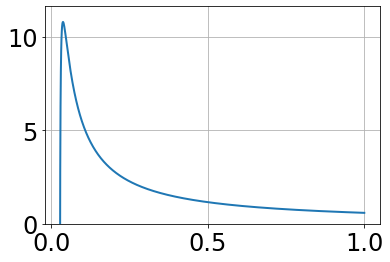

/tmp/ipykernel_4044372/1066407475.py:2: RuntimeWarning: invalid value encountered in sqrt
  return (1.-Ls*(1.+np.sqrt(1./(alpha-(gamma/np.cbrt(lc))))))/lc


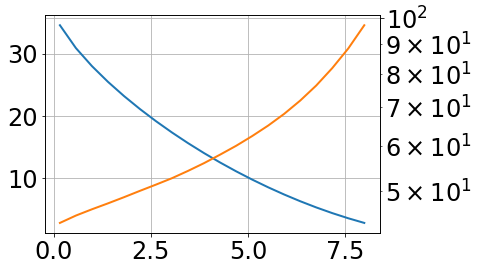

In [80]:
def nc_func_of_lcrit(lc, Ls, alpha, gamma):
    return (1.-Ls*(1.+np.sqrt(1./(alpha-(gamma/np.cbrt(lc))))))/lc

from scipy.optimize import minimize
# Define the negative of the function
def neg_nc_func_of_lcrit(lc, Ls, alpha, gamma):
    return -nc_func_of_lcrit(lc, Ls, alpha, gamma)

# Parameters
Ls = .3
alpha = 10.0
gamma = 3

# Initial guess for lc
initial_guess = ((gamma/alpha)**3)*1.1

# Minimize the negative function
result = minimize(neg_nc_func_of_lcrit, initial_guess, args=(Ls, alpha, gamma))

# The maximum value of the original function
max_value = -result.fun
max_lc = result.x

lc_arr = np.linspace(.001, 1, 1000)
plt.plot(lc_arr, nc_func_of_lcrit(lc_arr, Ls, alpha, gamma))
plt.ylim(0)

print(f"Maximum value: {max_value}")
print(f"At lc: {max_lc}")
plt.show()

Ls_arr = np.linspace(.01, .5, 20)
Nmax_arr = []
lcrit_arr = []

fig, axarr = plt.subplots(1,1, figsize=(6, 4))

for Ls in Ls_arr:
    result = minimize(neg_nc_func_of_lcrit, initial_guess, args=(Ls, alpha, gamma), method='Nelder-Mead')
    Nmax_arr.append(-result.fun)
    lcrit_arr.append(result.x)
axarr.plot(Ls_arr*16, Nmax_arr)
axtwin = axarr.twinx()
axtwin.plot(Ls_arr*16, np.array(lcrit_arr)*16/.01, color='tab:orange')
#axtwin.set_ylim(10)
axtwin.set_yscale('log')


/tmp/ipykernel_4044372/2205103154.py:5: RuntimeWarning: invalid value encountered in sqrt
  return (L-Ls*(1.+np.sqrt(c/(a-(b/np.cbrt(lc))))))/lc


(0.0, 86.14165496919502)

Maximum value: 82.4541159663849
At lc: [0.04644046]


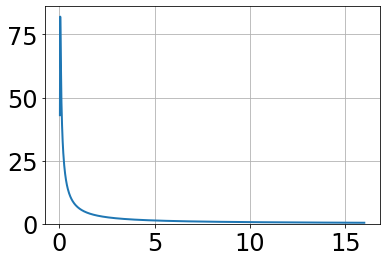

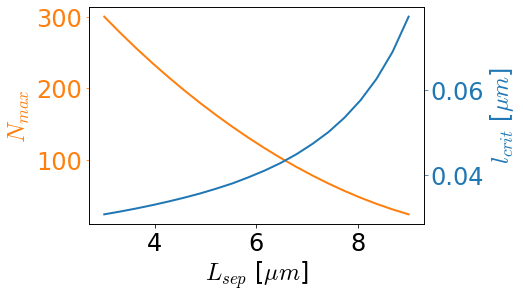

In [112]:
def nc_func_of_lcrit_dim(lc, L, Ls, alpha, gamma, kappa, nu):
    a = alpha*nu
    b = (8.*gamma*np.pi/3.)*np.power(4*np.pi*alpha*alpha/3.,2./3.)
    c =.25*kappa
    return (L-Ls*(1.+np.sqrt(c/(a-(b/np.cbrt(lc))))))/lc

from scipy.optimize import minimize
# Define the negative of the function
def neg_nc_func_of_lcrit_dim(lc, L, Ls, alpha, gamma, kappa, nu):
    return -nc_func_of_lcrit_dim(lc, L, Ls, alpha, gamma, kappa, nu)

kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
L = 16
Ls=7

# Parameters
#Ls = .3
#alpha = 10.0
#gamma = 3

a = alpha*nu
b = (8.*gamma*np.pi/3.)*np.power(4*np.pi*alpha*alpha/3.,2./3.)
c =.25*kappa# Initial guess for lc
initial_guess = ((b/a)**3)*1.1

# Minimize the negative function
result = minimize(neg_nc_func_of_lcrit_dim, initial_guess, args=(L, Ls, alpha, gamma, kappa, nu))

# The maximum value of the original function
max_value = -result.fun
max_lc = result.x

lc_arr = np.linspace(.001, L, 1000)
plt.plot(lc_arr, nc_func_of_lcrit_dim(lc_arr, L, Ls, alpha, gamma, kappa, nu))
plt.ylim(0)

print(f"Maximum value: {max_value}")
print(f"At lc: {max_lc}")
plt.show()

Ls_arr = np.linspace(3, 9, 20)
Nmax_arr = []
lcrit_arr = []

fig, axarr = plt.subplots(1,1, figsize=(6, 4))

for Ls in Ls_arr:
    result = minimize(neg_nc_func_of_lcrit_dim, initial_guess, args=(L, Ls, alpha, gamma, kappa, nu), method='Nelder-Mead')
    Nmax_arr.append(-result.fun)
    lcrit_arr.append(result.x)
_ = axarr.plot(Ls_arr, Nmax_arr, color='tab:orange')
_ = axtwin = axarr.twinx()
_ = axtwin.plot(Ls_arr, np.array(lcrit_arr))
_ = axarr.set_xlabel(r"$L_{sep}$ [$\mu m$]")
_ = axarr.set_ylabel(r"$N_{max}$")
_ = axtwin.set_ylabel(r"$l_{crit}$ [$\mu m$]")

_ = axarr.yaxis.label.set_color('tab:orange')
_ = axarr.tick_params(axis='y', colors='tab:orange')
_ = axtwin.yaxis.label.set_color('tab:blue')
_ = axtwin.tick_params(axis='y', colors='tab:blue')
# Remove gridlines
axtwin.grid(False)
axarr.grid(False)

#axtwin.set_ylim(10)
#axtwin.set_yscale('log')


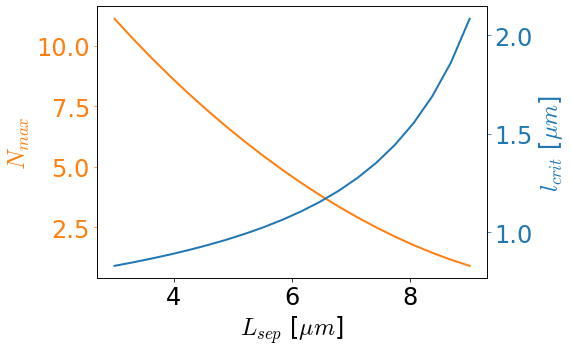

In [113]:
def nc_func_of_lcrit_dim(lc, L, Ls, alpha, gamma, kappa, nu):
    a = alpha*nu
    b = (8.*gamma*np.pi/3.)*np.power(4*np.pi*alpha*alpha/3.,2./3.)
    c =.25*kappa
    return (L-Ls*(1.+np.sqrt(c/(a-(b/np.cbrt(lc))))))/lc

from scipy.optimize import minimize
# Define the negative of the function
def neg_nc_func_of_lcrit_dim(lc, L, Ls, alpha, gamma, kappa, nu):
    return -nc_func_of_lcrit_dim(lc, L, Ls, alpha, gamma, kappa, nu)

kappa = 0.0822
nu = 4.1
gamma = 0.45
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
L = 16
Ls=7

# Parameters
#Ls = .3
#alpha = 10.0
#gamma = 3

a = alpha*nu
b = (8.*gamma*np.pi/3.)*np.power(4*np.pi*alpha*alpha/3.,2./3.)
c =.25*kappa# Initial guess for lc
initial_guess = ((b/a)**3)*1.1

Ls_arr = np.linspace(3, 9, 20)
Nmax_arr = []
lcrit_arr = []
fig, axarr = plt.subplots(1,1, figsize=(7, 5), sharex='col', sharey='row' )
for Ls in Ls_arr:
    result = minimize(neg_nc_func_of_lcrit_dim, initial_guess, args=(L, Ls, alpha, gamma, kappa, nu), method='Nelder-Mead')
    Nmax_arr.append(-result.fun)
    lcrit_arr.append(result.x)
_ = axarr.plot(Ls_arr, Nmax_arr, color='tab:orange')
_ = axtwin = axarr.twinx()
_ = axtwin.plot(Ls_arr, np.array(lcrit_arr))
_ = axarr.set_xlabel(r"$L_{sep}$ [$\mu m$]")
_ = axarr.set_ylabel(r"$N_{max}$")
_ = axtwin.set_ylabel(r"$l_{crit}$ [$\mu m$]")

_ = axarr.yaxis.label.set_color('tab:orange')
_ = axarr.tick_params(axis='y', colors='tab:orange')
_ = axtwin.yaxis.label.set_color('tab:blue')
_ = axtwin.tick_params(axis='y', colors='tab:blue')

axtwin.grid(False)
axarr.grid(False)

#axtwin.set_ylim(10)
#axtwin.set_yscale('log')


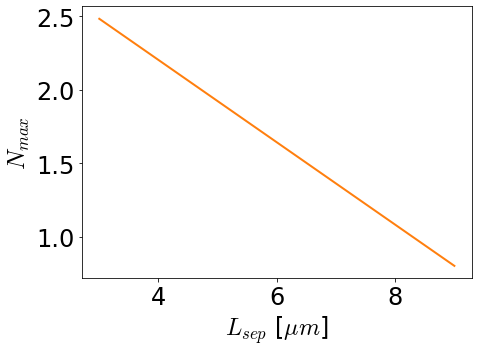

In [25]:
def nc_func_of_lcrit_dim(lc, L, Ls, alpha, gamma, kappa, nu):
    a = alpha*nu
    b = (8.*gamma*np.pi/3.)*np.power(4*np.pi*alpha*alpha/3.,2./3.)
    c =.25*kappa
    return (L-Ls*(1.+np.sqrt(c/(a-(b/np.cbrt(lc))))))/lc

from scipy.optimize import minimize
# Define the negative of the function
def neg_nc_func_of_lcrit_dim(lc, L, Ls, alpha, gamma, kappa, nu):
    return -nc_func_of_lcrit_dim(lc, L, Ls, alpha, gamma, kappa, nu)

kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
L = 16
Ls=7

# Parameters
#Ls = .3
#alpha = 10.0
#gamma = 3

a = alpha*nu
b = (8.*gamma*np.pi/3.)*np.power(4*np.pi*alpha*alpha/3.,2./3.)
c =.25*kappa# Initial guess for lc
initial_guess = ((b/a)**3)*1.1

fig, axarr = plt.subplots(1,1, figsize=(7, 5), sharex='col', sharey='row' )

Ls_arr = np.linspace(3, 9, 20)
Nmax_arr = nc_func_of_lcrit_dim(80*b, L, Ls_arr, alpha, gamma, kappa, nu)
# for Ls in Ls_arr:
#     Nmax_arr.append()
    # result = minimize(neg_nc_func_of_lcrit_dim, initial_guess, args=(L, Ls, alpha, gamma, kappa, nu), method='Nelder-Mead')
    # Nmax_arr.append(-result.fun)
    # lcrit_arr.append(result.x)
_ = axarr.plot(Ls_arr, Nmax_arr, color='tab:orange')
# _ = axtwin = axarr.twinx()
# _ = axtwin.plot(Ls_arr, np.array(lcrit_arr))
_ = axarr.set_xlabel(r"$L_{sep}$ [$\mu m$]")
_ = axarr.set_ylabel(r"$N_{max}$")
# _ = axtwin.set_ylabel(r"$l_{crit}$ [$\mu m$]")

# _ = axarr.yaxis.label.set_color('tab:orange')
# _ = axarr.tick_params(axis='y', colors='tab:orange')
# _ = axtwin.yaxis.label.set_color('tab:blue')
# _ = axtwin.tick_params(axis='y', colors='tab:blue')

# axtwin.grid(False)
axarr.grid(False)

#axtwin.set_ylim(10)
#axtwin.set_yscale('log')


# Supplement figures

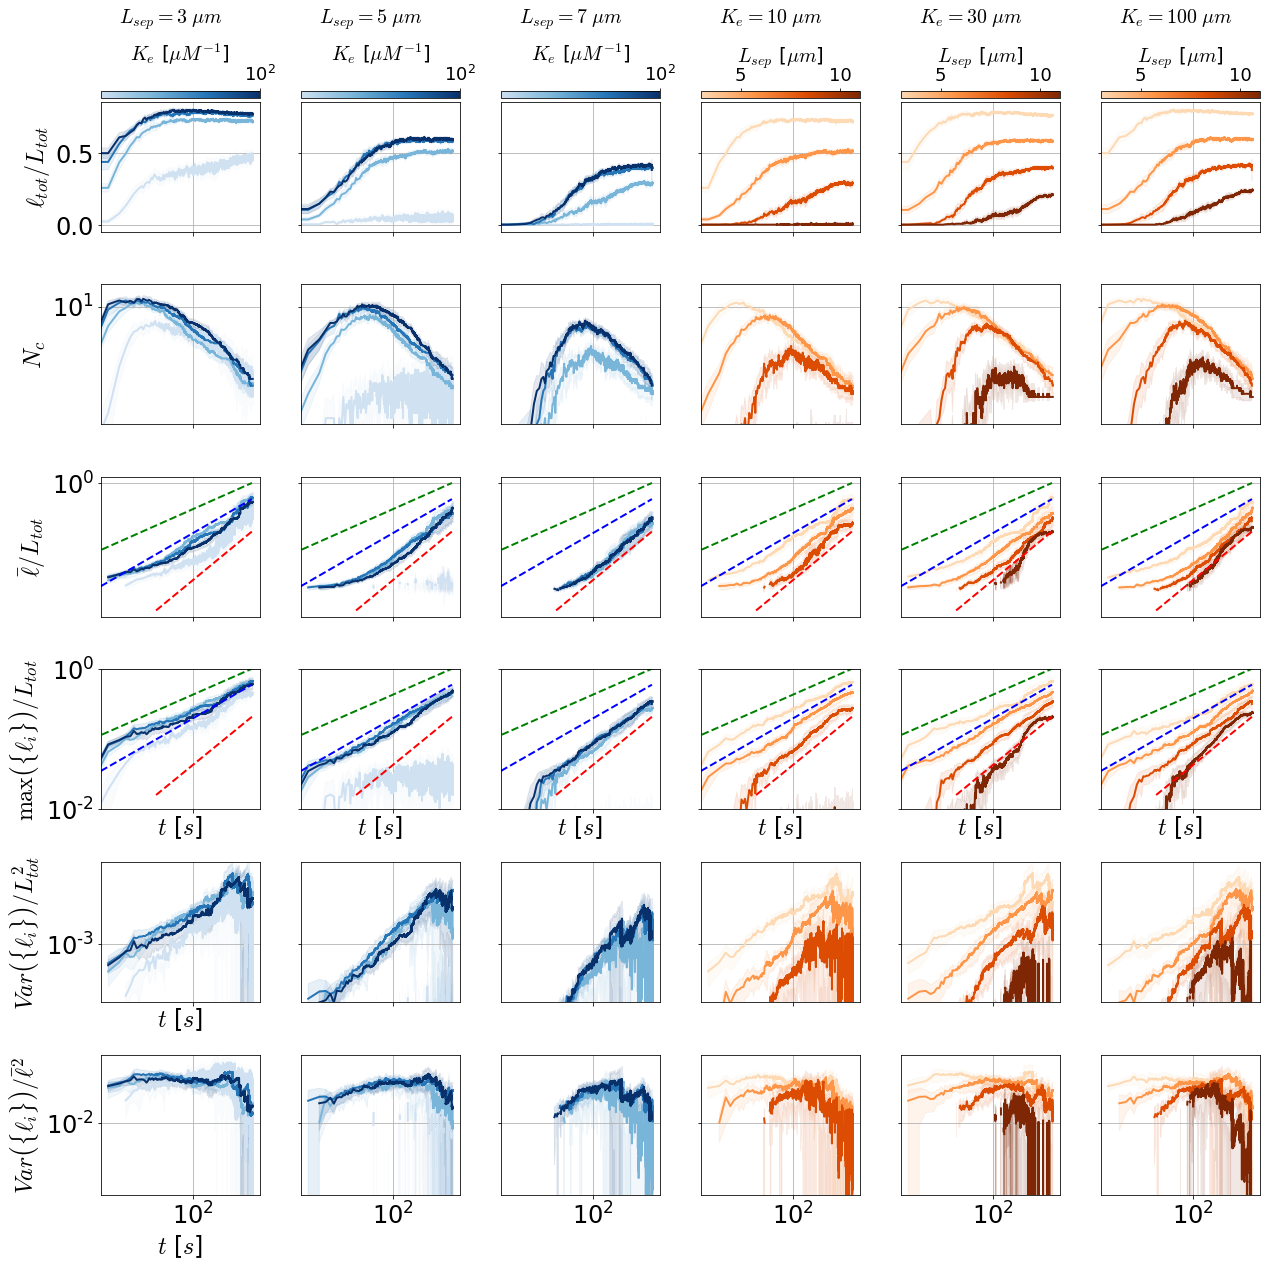

In [43]:
n_shades = 4

cmap = plt.cm.Blues
blue_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', blue_colors)

cmap = plt.cm.Oranges
orange_colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
orange_cmap = mcolors.LinearSegmentedColormap.from_list('custom_oranges', orange_colors)

fig, axarr = plt.subplots(6,6, figsize=(18, 18), sharex=True, sharey='row' )

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    labels_to_graph_dict = {
        r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke3/",
        r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke10/",
        r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30/",
        r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke100",
    }
    graph_cluster_stat_col(axarr[:,0], h5d, labels_to_graph_dict, blue_colors)
    _ = axarr[0,0].text(1, 1.4, "$L_{sep} = 3\; \mu m$")

    labels_to_graph_dict = {
        r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
        r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
        r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
        r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
    }
    graph_cluster_stat_col(axarr[:,1], h5d, labels_to_graph_dict, blue_colors)
    _ = axarr[0,1].text(1, 1.4, "$L_{sep} = 5\; \mu m$")

    labels_to_graph_dict = {
        r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke3/",
        r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke10/",
        r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke30/",
        r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke100",
    }
    graph_cluster_stat_col(axarr[:,2], h5d, labels_to_graph_dict, blue_colors)
    _ = axarr[0,2].text(1, 1.4, "$L_{sep} = 7\; \mu m$")

    labels_to_graph_dict = {
        r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke10/",
        r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
        r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke10/",
        r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke10",
    }
    graph_cluster_stat_col(axarr[:,3], h5d, labels_to_graph_dict, orange_colors)
    _ = axarr[0,3].text(1, 1.4, "$K_{e} = 10\; \mu m$")
    

    labels_to_graph_dict = {
        r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30/",
        r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
        r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke30/",
        r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
    }
    graph_cluster_stat_col(axarr[:,4], h5d, labels_to_graph_dict, orange_colors)
    _ = axarr[0,4].text(1, 1.4, "$K_{e} = 30\; \mu m$")

    labels_to_graph_dict = {
        r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke100/",
        r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100/",
        r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke100/",
        r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke100",
    }
    graph_cluster_stat_col(axarr[:,5], h5d, labels_to_graph_dict, orange_colors)
    _ = axarr[0,5].text(1, 1.4, "$K_{e} = 100\; \mu m$")


_ = axarr[0,0].set_ylabel("$\ell_{tot} / L_{tot}$")

_ = axarr[1,0].set_ylabel("$N_c$")
_ = axarr[1,0].set_yscale("log")
_ = axarr[1,0].set_ylim(.5)

_ = axarr[2,0].set_ylabel( r"$\bar{\ell} / L_{tot}$")
_ = axarr[2,0].set_yscale("log")

_ = axarr[3,0].set_ylabel( r"$\max\left(\{\ell_i\}\right) / L_{tot}$")
_ = axarr[3,0].set_yscale("log")
_ = axarr[3,0].set_ylim(.01, 1)

_ = axarr[4,0].set_ylabel(r"$Var\left(\{\ell_i\}\right)/ L_{tot}^2$")
_ = axarr[4,0].set_ylim(.00005)
_ = axarr[4,0].set_yscale("log")
_ = axarr[4,0].set_xlabel("$t$ [$s$]")

_ = axarr[5,0].set_ylabel(r"$Var\left(\{\ell_i\}\right)/ \bar{\ell}^2$")
_ = axarr[5,0].set_ylim(.00005)
_ = axarr[5,0].set_yscale("log")
_ = axarr[5,0].set_xlabel("$t$ [$s$]")

for ax in axarr[3,:]:
    _ = ax.set_xscale("log")
    _ = ax.set_xlabel("$t$ [$s$]")
    
cbars = []
for ax in axarr[0,:3]:
    norm = mcolors.LogNorm(vmin=3, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=blue_cmap, norm=norm)
    sm.set_array([])
    cax0 = make_axes_locatable(ax).append_axes("top", size="5%", pad=0.06)
    cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04,  )
    cbar.set_label('$K_e$ [$\mu M^{-1}$]', fontsize=20)
    cbars.append(cbar)

for ax in axarr[0,3:]:
    norm = mcolors.Normalize(vmin=3, vmax=11)
    sm = plt.cm.ScalarMappable(cmap=orange_cmap, norm=norm)
    sm.set_array([])
    cax1 = make_axes_locatable(ax).append_axes("top", size="5%", pad=0.06)
    cbar = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04 )
    cbar.set_label('$L_{sep}$ [$\mu m$]', fontsize=20)
    cbars.append(cbar)

for cbar in cbars:
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=18)

for i in [2,3]:

    _ = axarr[i,0].plot(np.arange(10, 4000), .006*np.power(np.arange(10, 4000), 3./7.), 'r--')
    _ = axarr[i,1].plot(np.arange(10, 4000), .006*np.power(np.arange(10, 4000), 3./7.), 'r--')
    _ = axarr[i,2].plot(np.arange(10, 4000), .006*np.power(np.arange(10, 4000), 3./7.), 'r--')
    _ = axarr[i,3].plot(np.arange(10, 4000), .006*np.power(np.arange(10, 4000), 3./7.), 'r--')
    _ = axarr[i,4].plot(np.arange(10, 4000), .006*np.power(np.arange(10, 4000), 3./7.), 'r--')
    _ = axarr[i,5].plot(np.arange(10, 4000), .006*np.power(np.arange(10, 4000), 3./7.), 'r--')
    # _ = axarr[2,4].plot(np.arange(10, 4000), .000009*np.power(np.arange(10, 4000), 3./2.), 'g--')

    _ = axarr[i,0].plot(np.arange(.1, 4000), .05*np.power(np.arange(.1, 4000), 3./10.), 'b--')
    _ = axarr[i,1].plot(np.arange(.1, 4000), .05*np.power(np.arange(.1, 4000), 3./10.), 'b--')
    _ = axarr[i,2].plot(np.arange(.1, 4000), .05*np.power(np.arange(.1, 4000), 3./10.), 'b--')
    _ = axarr[i,3].plot(np.arange(.1, 4000), .05*np.power(np.arange(.1, 4000), 3./10.), 'b--')
    _ = axarr[i,4].plot(np.arange(.1, 4000), .05*np.power(np.arange(.1, 4000), 3./10.), 'b--')
    _ = axarr[i,5].plot(np.arange(.1, 4000), .05*np.power(np.arange(.1, 4000), 3./10.), 'b--')

    _ = axarr[i,0].plot(np.arange(.1, 4000), .15*np.power(np.arange(.1, 4000), 3./13.), 'g--')
    _ = axarr[i,1].plot(np.arange(.1, 4000), .15*np.power(np.arange(.1, 4000), 3./13.), 'g--')
    _ = axarr[i,2].plot(np.arange(.1, 4000), .15*np.power(np.arange(.1, 4000), 3./13.), 'g--')
    _ = axarr[i,3].plot(np.arange(.1, 4000), .15*np.power(np.arange(.1, 4000), 3./13.), 'g--')
    _ = axarr[i,4].plot(np.arange(.1, 4000), .15*np.power(np.arange(.1, 4000), 3./13.), 'g--')
    _ = axarr[i,5].plot(np.arange(.1, 4000), .15*np.power(np.arange(.1, 4000), 3./13.), 'g--')

fig.tight_layout()
fig.savefig("Figure3/fig3_supp_cond_dyn_all_stats.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_supp_cond_dyn_all_stats.png", dpi=300, bbox_inches="tight")

